In [1]:
import os
from IPython.display import clear_output

def install_packages():
    print("Installing Gradio, LangGraph, Gemini, and PDF Loaders...")
    !pip install -qU gradio langgraph langchain-google-genai langchain-community chromadb duckduckgo-search langchain langchain-huggingface sentence_transformers pypdf
    clear_output()
    print("✅ Packages Installed!")

In [2]:
install_packages()

✅ Packages Installed!


In [3]:
import gradio as gr
import getpass
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_community.document_loaders import PyPDFLoader
from langchain_huggingface import HuggingFaceEmbeddings


In [36]:
import json
import datetime
from typing import List , Dict,Any
import uuid  # <--- ✅ ADDED THIS MISSING IMPORT


In [23]:
!pip install -qU ddgs

print("⏳ Loading embedding model (approx. 10s)...")
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# --- TOOLS ---
web_search_tool = DuckDuckGoSearchRun()

# --- GLOBAL STORE ---
VECTOR_STORE = None  # Holds the RAG database

⏳ Loading embedding model (approx. 10s)...


In [22]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("🔑 Enter your Google Gemini API Key: ")

# --- MODELS ---
# Gemini for Text Generation
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.7)

# Local Embeddings (HuggingFace) to avoid Rate Limits

In [24]:
def process_file(file_obj):
    """
    Extracts text from uploaded PDF or TXT files.
    This replaces the manual paste.
    """
    global VECTOR_STORE

    if file_obj is None:
        return "⚠️ No file uploaded."

    try:
        text = ""
        # 1. Determine file type and load
        if file_obj.name.endswith('.pdf'):
            loader = PyPDFLoader(file_obj.name)
            pages = loader.load()
            text = "\n\n".join([p.page_content for p in pages])
        else:
            # Assume text file
            with open(file_obj.name, 'r') as f:
                text = f.read()

        if not text:
            return "⚠️ Could not extract text. File might be empty or scanned image."

        # 2. Chunk and Store in ChromaDB
        print(f"Indexing {len(text)} characters...")

        # Split text into chunks (simple split for demo)
        from langchain_text_splitters import RecursiveCharacterTextSplitter
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        docs = text_splitter.create_documents([text])

        # Create/Update Vector Store
        VECTOR_STORE = Chroma.from_documents(docs, embeddings)

        return f"✅ Document processed! Added {len(docs)} chunks to the Brain. You can now ask questions."

    except Exception as e:
        return f"❌ Error processing file: {str(e)}"

In [37]:
class AgentState(TypedDict):
    query: str
    research_output: str
    web_output: str
    rag_context: str
    final_answer: str
    interaction_data: Dict[str, Any]

# --- NODE FUNCTIONS ---

def research_node(state: AgentState):
    query = state['query']
    response = llm.invoke(f"Provide a theoretical, academic summary of: {query}")
    return {"research_output": response.content}

def web_search_node(state: AgentState):
    query = state['query']
    results = web_search_tool.invoke(query)
    response = llm.invoke(f"Summarize these search results for '{query}':\n\n{results}")
    return {"web_output": response.content}

def synth_node(state: AgentState):
    prompt = f"""
    Combine these into a final answer:
    1. Theory: {state['research_output']}
    2. Web Info: {state['web_output']}
    """
    response = llm.invoke(prompt)
    return {"final_answer": response.content}

def rag_retrieve_node(state: AgentState):
    global VECTOR_STORE
    if VECTOR_STORE is None:
        return {"rag_context": "NO DOCUMENT LOADED."}

    docs = VECTOR_STORE.similarity_search(state['query'], k=4)
    context = "\n\n".join([d.page_content for d in docs])
    return {"rag_context": context}

def rag_brain_node(state: AgentState):
    context = state['rag_context']
    if context == "NO DOCUMENT LOADED.":
        return {"final_answer": "⚠️ Please upload a document first!"}

    prompt = f"Answer based ONLY on context:\n{context}\n\nQuestion: {state['query']}"
    response = llm.invoke(prompt)
    return {"final_answer": response.content}
def save_history_node(state: AgentState):
    """
    Instead of making a string, we create a structured data object.
    This allows us to format it perfectly later.
    """
    time_now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Determine mode based on context availability
    mode = "🌍 DEEP RESEARCH" if state.get('web_output') else "📄 DOC RAG"

    data_object = {
        "timestamp": time_now,
        "mode": mode,
        "query": state['query'],
        "answer": state['final_answer'],
        # We can store extra metadata if needed for future reloading
        "raw_research": state.get('research_output', ''),
        "raw_web": state.get('web_output', '')
    }

    return {"interaction_data": data_object}


In [39]:
r_builder = StateGraph(AgentState)
r_builder.add_node("research", research_node)
r_builder.add_node("web", web_search_node)
r_builder.add_node("synth", synth_node)
r_builder.add_node("saver", save_history_node)
r_builder.set_entry_point("research")
r_builder.add_edge("research", "web")
r_builder.add_edge("web", "synth")
r_builder.add_edge("synth", "saver")
r_builder.add_edge("saver", END)
research_graph = r_builder.compile()

# RAG Graph
rag_builder = StateGraph(AgentState)
rag_builder.add_node("retrieve", rag_retrieve_node)
rag_builder.add_node("brain", rag_brain_node)
rag_builder.add_node("saver", save_history_node)
rag_builder.set_entry_point("retrieve")
rag_builder.add_edge("retrieve", "brain")
rag_builder.add_edge("brain", "saver")
rag_builder.add_edge("saver", END)
rag_graph = rag_builder.compile()


🌍 ARCHITECTURE 1: DEEP RESEARCH FLOW


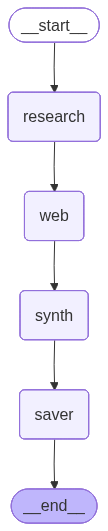


📄 ARCHITECTURE 2: RAG DOCUMENT FLOW


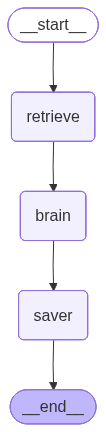

In [41]:
from IPython.display import Image, display

print("="*50)
print("🌍 ARCHITECTURE 1: DEEP RESEARCH FLOW")
print("="*50)
try:
    # Visualize Research Graph
    display(Image(research_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not render image: {e}")

print("\n" + "="*50)
print("📄 ARCHITECTURE 2: RAG DOCUMENT FLOW")
print("="*50)
try:
    # Visualize RAG Graph
    display(Image(rag_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not render image: {e}")

In [42]:
def export_formatted_chat(history_list):
    """
    Takes the structured history and generates a beautiful Markdown file.
    """
    if not history_list:
        return None

    # Generate unique session ID using uuid
    session_id = str(uuid.uuid4())[:8]
    filename = f"Session_Log_{session_id}.md"

    with open(filename, "w", encoding="utf-8") as f:
        # File Header
        f.write(f"# 🧠 Multi-Agent Session Log\n")
        f.write(f"**Date:** {datetime.datetime.now().strftime('%Y-%m-%d')}\n")
        f.write(f"**Session ID:** `{session_id}`\n\n")
        f.write("---\n\n")

        # Loop through interactions
        for i, entry in enumerate(history_list, 1):
            f.write(f"### 🟢 Interaction {i} | {entry['timestamp']}\n")
            f.write(f"**Mode:** `{entry['mode']}`\n\n")

            f.write("#### 👤 User Query\n")
            f.write(f"> {entry['query']}\n\n")

            f.write("#### 🤖 System Answer\n")
            f.write(f"{entry['answer']}\n\n")

            f.write("---\n\n")

    return filename

def run_research_ui(query, history):
    if not query: return "Enter topic", history
    result = research_graph.invoke({"query": query})

    # Store the structured object
    data = result.get("interaction_data", {})
    history.append(data)

    return result["final_answer"], history

def run_rag_ui(query, history):
    if not query: return "Enter question", history
    result = rag_graph.invoke({"query": query})

    # Store the structured object
    data = result.get("interaction_data", {})
    history.append(data)

    return result["final_answer"], history

# --- UI LAYOUT ---
with gr.Blocks() as demo:
    session_history = gr.State([])

    gr.Markdown("# 🤖 Professional Multi-Agent System")
    gr.Markdown("Conversations are saved in structured Markdown format.")

    with gr.Tabs():
        # TAB 1: RESEARCH
        with gr.TabItem("🌍 Deep Research"):
            r_in = gr.Textbox(label="Topic")
            r_btn = gr.Button("Research", variant="primary")
            r_out = gr.Markdown(label="Result")

            r_btn.click(
                run_research_ui,
                inputs=[r_in, session_history],
                outputs=[r_out, session_history]
            )

        # TAB 2: RAG
        with gr.TabItem("📄 RAG"):
            f_up = gr.File(label="Upload PDF/TXT")
            f_stat = gr.Textbox(label="Status", interactive=False)
            f_up.change(process_file, inputs=f_up, outputs=f_stat)

            rag_in = gr.Textbox(label="Question")
            rag_btn = gr.Button("Ask", variant="primary")
            rag_out = gr.Markdown(label="Answer")

            rag_btn.click(
                run_rag_ui,
                inputs=[rag_in, session_history],
                outputs=[rag_out, session_history]
            )

    # DOWNLOAD SECTION
    gr.Markdown("### 💾 Session Controls")
    with gr.Row():
        dl_btn = gr.Button("📥 Download Formatted History (.md)")
        dl_file = gr.File(label="Exported File")

    dl_btn.click(export_formatted_chat, inputs=session_history, outputs=dl_file)

print("🚀 Launching Professional UI...")
demo.launch(debug=True)

🚀 Launching Professional UI...
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1563f7de41f76f3263.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Indexing 39615 characters...
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1563f7de41f76f3263.gradio.live
